
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.


# 1. Read and visualise the data

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [31]:
# read the dataset
retail_df = pd.read_csv("Online_Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [32]:
# basics of the df
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# 2. Clean the data

In [33]:
# missing values
round(100*(retail_df.isnull().sum())/len(retail_df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [34]:
# drop all rows having missing values
retail_df = retail_df.dropna()
retail_df.shape

(406829, 8)

In [35]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [36]:
# new column: amount 
retail_df['amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


# 3. Prepare the data for modelling

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [37]:
# monetary
grouped_df = retail_df.groupby('CustomerID')['amount'].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [38]:
# frequency
frequency = retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'frequency']
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [39]:
# merge the two dfs
grouped_df = pd.merge(grouped_df, frequency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [40]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [41]:
# recency
# convert to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], 
                                          format='%d-%m-%Y %H:%M')

In [42]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [43]:
# compute the max date
max_date = max(retail_df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [44]:
# compute the diff
retail_df['diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [45]:
# recency
last_purchase = retail_df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [46]:
# merge
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [47]:
# number of days only
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


{'whiskers': [<matplotlib.lines.Line2D at 0x25080021ac8>,
 'caps': [<matplotlib.lines.Line2D at 0x25080021ef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x250800216a0>],
 'medians': [<matplotlib.lines.Line2D at 0x25080010828>],
 'fliers': [<matplotlib.lines.Line2D at 0x25080010b70>],
 'means': []}

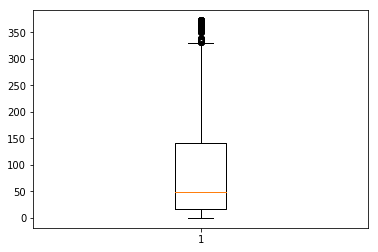

In [48]:
# 1. outlier treatment
plt.boxplot(grouped_df['recency'])

In [49]:
# two types of outliers:
# - statistical
# - domain specific

In [50]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]



In [52]:
# 2. rescaling
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

C:\Users\foram.r.solanki\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\foram.r.solanki\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(4293, 3)

In [53]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


### Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [54]:
## Hopkins Statistics test 

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [55]:
hopkins(rfm_df_scaled)

0.9600436492953436

#### If the value of Hopkins statistic is close to 1, then we can conclude that the dataset is significantly a clusterable data.

# 4. Modelling

In [56]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [57]:
kmeans.labels_

array([2, 3, 1, ..., 2, 1, 1])

In [58]:
# help(KMeans)

## Finding the Optimal Number of Clusters

### SSD

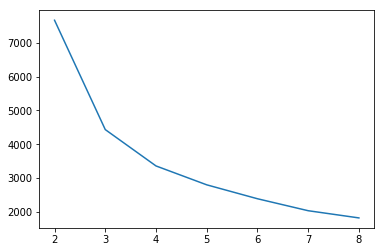

In [59]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(range_n_clusters,ssd)
#plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [60]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.4817567985759693
For n_clusters=5, the silhouette score is 0.4662700564189704
For n_clusters=6, the silhouette score is 0.4171229822428261
For n_clusters=7, the silhouette score is 0.41498253869697127
For n_clusters=8, the silhouette score is 0.40620782365985825


In [61]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [62]:
kmeans.labels_

array([0, 2, 1, ..., 0, 1, 1])

In [63]:
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,0


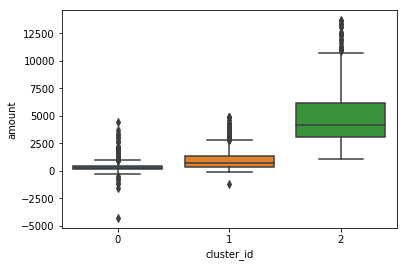

In [64]:
# plot
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

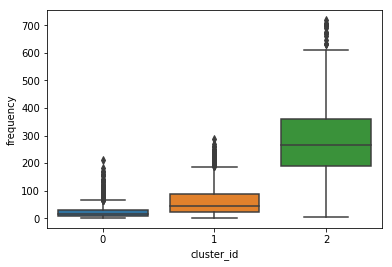

In [65]:
sns.boxplot(x='cluster_id', y='frequency', data=grouped_df)

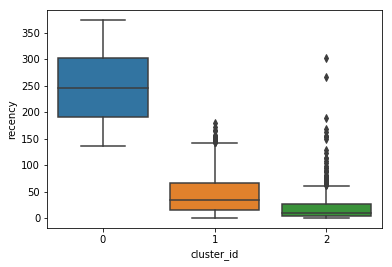

In [66]:
sns.boxplot(x='cluster_id', y='recency', data=grouped_df)

Cluster Analysis: In the final model building with k=3 (which is the best and optimal number of clusters identified using the elbow method and Silhouette Analysis), we can see that 

- customers in cluster 2 are high-value customers also contributing to the company's revenue.
- customers in cluster 2 are highly frequent customers whereas customers in cluster 0 and cluster 1 are medium and less frequent customers.
- customers in cluster 2 and 1  have the most recency however customers in cluster 0 has very low recency.